In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

# 1. 데이터셋 불러오기
데이터셋은 torchvision 패키지에서 제공하는 STL10 dataset을 이용하겠습니다. STL10 dataset은 10개의 label을 갖으며 train dataset 5000개, test dataset 8000개로 구성됩니다.

In [2]:
# specify path to data
path2data = './data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

Files already downloaded and verified
Files already downloaded and verified
5000
8000


In [3]:
# define transformation
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(64)
])

# apply transformation to dataset
train_ds.transform = transformation
val_ds.transform = transformation

# make dataloade
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

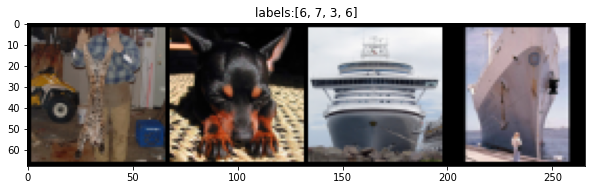

In [4]:
# check sample images
def show(img, y=None):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

np.random.seed(7)
torch.manual_seed(0)

grid_size=4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [val_ds[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

# 2. 모델 구축하기
코드는 https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/densenet.py 를 참고했습니다.

In [5]:
# DenseNet BottleNeck
class BottleNeck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channels = 4 * growth_rate

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(inner_channels),
            nn.ReLU(),
            nn.Conv2d(inner_channels, growth_rate, 3, stride=1, padding=1, bias=False)
        )

        self.shortcut = nn.Sequential()

    def forward(self, x):
        return torch.cat([self.shortcut(x), self.residual(x)], 1)


# Transition Block: reduce feature map size and number of channels
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

# DenseNet
class DenseNet(nn.Module):
    def __init__(self, nblocks, growth_rate=12, reduction=0.5, num_classes=10, init_weights=True):
        super().__init__()

        self.growth_rate = growth_rate
        inner_channels = 2 * growth_rate # output channels of conv1 before entering Dense Block

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, inner_channels, 7, stride=2, padding=3),
            nn.MaxPool2d(3, 2, padding=1)
        )

        self.features = nn.Sequential()

        for i in range(len(nblocks)-1):
            self.features.add_module('dense_block_{}'.format(i), self._make_dense_block(nblocks[i], inner_channels))
            inner_channels += growth_rate * nblocks[i]
            out_channels = int(reduction * inner_channels)
            self.features.add_module('transition_layer_{}'.format(i), Transition(inner_channels, out_channels))
            inner_channels = out_channels 
        
        self.features.add_module('dense_block_{}'.format(len(nblocks)-1), self._make_dense_block(nblocks[len(nblocks)-1], inner_channels))
        inner_channels += growth_rate * nblocks[len(nblocks)-1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU())

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(inner_channels, num_classes)

        # weight initialization
        if init_weights:
            self._initialize_weights()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def _make_dense_block(self, nblock, inner_channels):
        dense_block = nn.Sequential()
        for i in range(nblock):
            dense_block.add_module('bottle_neck_layer_{}'.format(i), BottleNeck(inner_channels, self.growth_rate))
            inner_channels += self.growth_rate
        return dense_block

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def DenseNet_121():
    return DenseNet([6, 12, 24, 6])

In [6]:
# check model
x = torch.randn(3, 3, 64, 64)
model = DenseNet_121()
output = model(x)
print(output.size())

torch.Size([3, 10])


In [7]:
# print model summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(model, (3, 64, 64), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]           3,552
         MaxPool2d-2           [-1, 24, 16, 16]               0
       BatchNorm2d-3           [-1, 24, 16, 16]              48
              ReLU-4           [-1, 24, 16, 16]               0
            Conv2d-5           [-1, 48, 16, 16]           1,152
       BatchNorm2d-6           [-1, 48, 16, 16]              96
              ReLU-7           [-1, 48, 16, 16]               0
            Conv2d-8           [-1, 12, 16, 16]           5,184
        BottleNeck-9           [-1, 36, 16, 16]               0
      BatchNorm2d-10           [-1, 36, 16, 16]              72
             ReLU-11           [-1, 36, 16, 16]               0
           Conv2d-12           [-1, 48, 16, 16]           1,728
      BatchNorm2d-13           [-1, 48, 16, 16]              96
             ReLU-14           [-1, 48,

# 3. 학습하기

In [8]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=8)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [9]:
# define the training parameters
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [10]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/29, current lr= 0.01
Copied best model weights!
train loss: 1.861370, val loss: 1.997488, accuracy: 31.75, time: 1.1671 min
----------
Epoch 1/29, current lr= 0.01
Copied best model weights!
train loss: 1.615296, val loss: 1.705774, accuracy: 35.46, time: 2.3452 min
----------
Epoch 2/29, current lr= 0.01
Copied best model weights!
train loss: 1.503962, val loss: 1.568750, accuracy: 38.36, time: 3.5169 min
----------
Epoch 3/29, current lr= 0.01
train loss: 1.435693, val loss: 1.923692, accuracy: 35.93, time: 4.6666 min
----------
Epoch 4/29, current lr= 0.01
Copied best model weights!
train loss: 1.340621, val loss: 1.495077, accuracy: 45.41, time: 5.8124 min
----------
Epoch 5/29, current lr= 0.01
train loss: 1.266279, val loss: 1.762041, accuracy: 40.14, time: 6.9688 min
----------
Epoch 6/29, current lr= 0.01
Copied best model weights!
train loss: 1.172397, val loss: 1.234932, accuracy: 54.61, time: 8.1255 min
----------
Epoch 7/29, current lr= 0.01
train loss: 1.095819, va

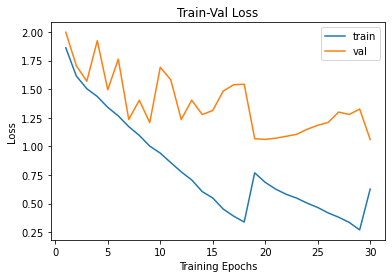

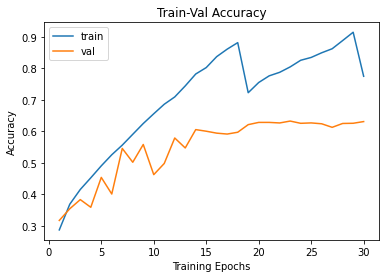

In [11]:
# Train-Validation progress
num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()